# Eye Disease Classification using Fundus Imaging

Dataset credits: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification

### Import all the Dependencies

In [24]:
import os

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Create variables for constants

In [25]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "training/eye_images",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4217 files belonging to 4 classes.
Metal device set to: Apple M1 Max


2023-04-15 12:47:44.319732: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-15 12:47:44.319891: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
class_names = dataset.class_names
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [6]:
len(dataset)

132

2023-04-15 12:47:44.486345: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


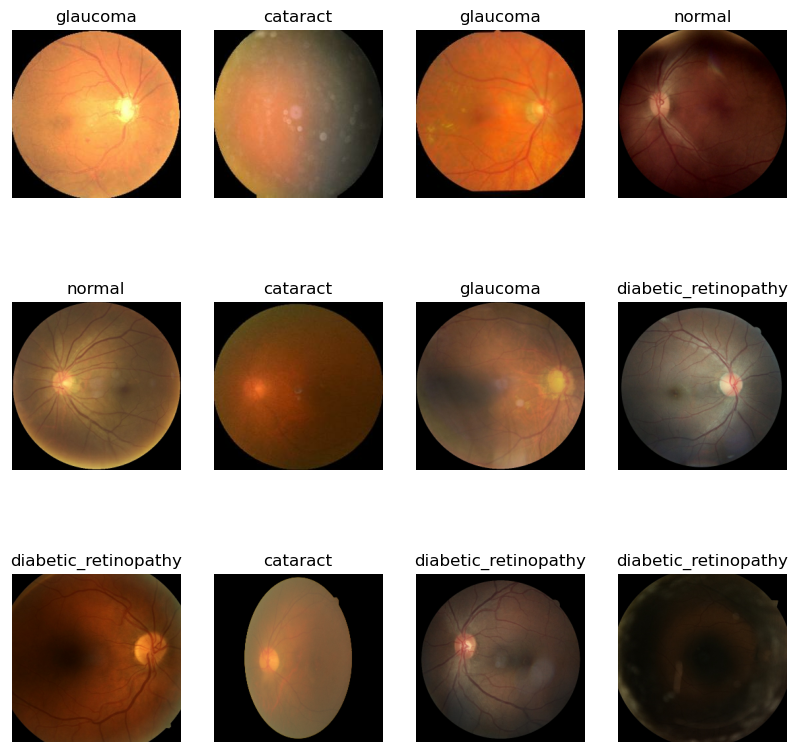

In [7]:
plt.figure(figsize = (10,10))

for image, label in dataset.take(1):
    for i in range (12):
        ax = plt.subplot(3, 4, i+1)
        # print(image.shape)
        # print(label.numpy)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [8]:
len(dataset)

132

In [9]:
def split_dataset(ds, train_split = 0.7, val_split = 0.2, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 42)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [11]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))


92
26
14


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Building the model

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


2023-04-15 13:05:24.056939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 1.2727 - accuracy: 0.3956

2023-04-15 13:05:49.899218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 28s 282ms/step - loss: 1.2727 - accuracy: 0.3956 - val_loss: 1.0832 - val_accuracy: 0.5309
Epoch 2/50
92/92 [==============================] - 26s 281ms/step - loss: 0.9761 - accuracy: 0.5546 - val_loss: 0.9827 - val_accuracy: 0.5721
Epoch 3/50
92/92 [==============================] - 26s 280ms/step - loss: 0.8922 - accuracy: 0.5795 - val_loss: 0.8759 - val_accuracy: 0.6145
Epoch 4/50
92/92 [==============================] - 26s 284ms/step - loss: 0.8114 - accuracy: 0.6343 - val_loss: 0.8191 - val_accuracy: 0.6012
Epoch 5/50
92/92 [==============================] - 26s 283ms/step - loss: 0.7394 - accuracy: 0.6871 - val_loss: 0.7212 - val_accuracy: 0.6885
Epoch 6/50
92/92 [==============================] - 27s 293ms/step - loss: 0.6819 - accuracy: 0.7051 - val_loss: 0.6945 - val_accuracy: 0.6970
Epoch 7/50
92/92 [==============================] - 26s 286ms/step - loss: 0.6337 - accuracy: 0.7290 - val_loss: 0.6296 - val_accuracy: 0.7406
Epoch 8/50